In [180]:
import warnings
warnings.filterwarnings('ignore')

In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [266]:
from matplotlib.colors import ListedColormap

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA 

# classification algorithm
from sklearn import svm 

# metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score

# model selection and parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# yellowbrick library  #pip install yellowbrick
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport

In [183]:
# example dataset
from sklearn.datasets import make_blobs

In [184]:
# appearence
sns.set_theme(style='darkgrid')
sns.set(rc={"figure.figsize":(12, 8)})
activities = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
c = ['#f05039', '#e57a77', '#eebab4', '#1f449c', '#3d65a5', '#7ca1cc']
col = ListedColormap(sns.color_palette(c).as_hex())

## MONKs

### Read datasets

In [185]:
monks1_test = pd.read_csv('../data/monks-1.test', header=None, delimiter=' ')
monks1_train = pd.read_csv('../data/monks-1.train', header=None, delimiter=' ')
monks2_test = pd.read_csv('../data/monks-2.test', header=None, delimiter=' ')
monks2_train = pd.read_csv('../data/monks-2.train', header=None, delimiter=' ')
monks3_test = pd.read_csv('../data/monks-3.test', header=None, delimiter=' ')
monks3_train = pd.read_csv('../data/monks-3.train', header=None, delimiter=' ')

ml_cup22_train = pd.read_csv('../data/ML-CUP22-TR.csv', header=None)
ml_cup22_test = pd.read_csv('../data/ML-CUP22-TS.csv', header=None)

In [186]:
monks1_test.shape, monks1_train.shape, monks2_test.shape, monks2_train.shape, monks3_test.shape, monks3_train.shape, 

((432, 9), (124, 9), (432, 9), (169, 9), (432, 9), (122, 9))

### Preprocess monks sets

Attribute information:
* class: 0, 1 
* a1:    1, 2, 3
* a2:    1, 2, 3
* a3:    1, 2
* a4:    1, 2, 3
* a5:    1, 2, 3, 4
* a6:    1, 2
* Id:    (A unique symbol for each instance)

#### set 1

In [187]:
test1 = monks1_test.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
test1.columns = columns
#test1.head()

In [188]:
train1 = monks1_train.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
train1.columns = columns
#train1.head()

In [189]:
len(train1)/len(test1)

0.28703703703703703

In [190]:
print('test: ', test1['a1'].value_counts()) 
print('train: ', train1['a1'].value_counts())

test:  1    144
2    144
3    144
Name: a1, dtype: int64
train:  1    45
2    42
3    37
Name: a1, dtype: int64


#### set 2

In [191]:
test2 = monks2_test.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
test2.columns = columns
train2 = monks2_train.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
train2.columns = columns

#### set 3

In [192]:
test3 = monks3_test.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
test3.columns = columns
train3 = monks3_train.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
train3.columns = columns

### Prepare TRAIN and TEST sets

In [193]:
# Splitting the train set in X and y
X_train1 = train1.copy()
y_train1 = X_train1['class']
X_train1 = X_train1.drop(columns='id')
X_train1 = X_train1.drop(columns='class')
X_train1 = X_train1.values
# Splitting the test set in X and y
X_test1 = test1.copy()
y_test1 = X_test1['class']
X_test1 = X_test1.drop(columns='id')
X_test1 = X_test1.drop(columns='class')
X_test1 = X_test1.values

In [194]:
# Splitting the train set in X and y
X_train2 = train2.copy()
y_train2 = X_train2['class']
X_train2 = X_train2.drop(columns='id')
X_train2 = X_train2.drop(columns='class')
X_train2 = X_train2.values
# Splitting the test set in X and y
X_test2 = test2.copy()
y_test2 = X_test2['class']
X_test2 = X_test2.drop(columns='id')
X_test2 = X_test2.drop(columns='class')
X_test2 = X_test2.values

In [195]:
# Splitting the train set in X and y
X_train3 = train3.copy()
y_train3 = X_train3['class']
X_train3 = X_train3.drop(columns='id')
X_train3 = X_train3.drop(columns='class')
X_train3 = X_train3.values
# Splitting the test set in X and y
X_test3 = test3.copy()
y_test3 = X_test3['class']
X_test3 = X_test3.drop(columns='id')
X_test3 = X_test3.drop(columns='class')
X_test3 = X_test3.values

In [255]:
print('Len of Train1: ', len(X_train1))
print('Len of Train2: ', len(X_train2))
print('Len of Train3: ', len(X_train3))

Len of Train1:  124
Len of Train2:  169
Len of Train3:  122


### Scaling 

In [197]:
st_scal = StandardScaler()
X_train1_st = st_scal.fit_transform(X_train1)
X_test1_st = st_scal.fit_transform(X_test1)

mm_scal = MinMaxScaler()
X_train1_mm = st_scal.fit_transform(X_train1)
X_test1_mm = st_scal.fit_transform(X_test1)

### Plotting

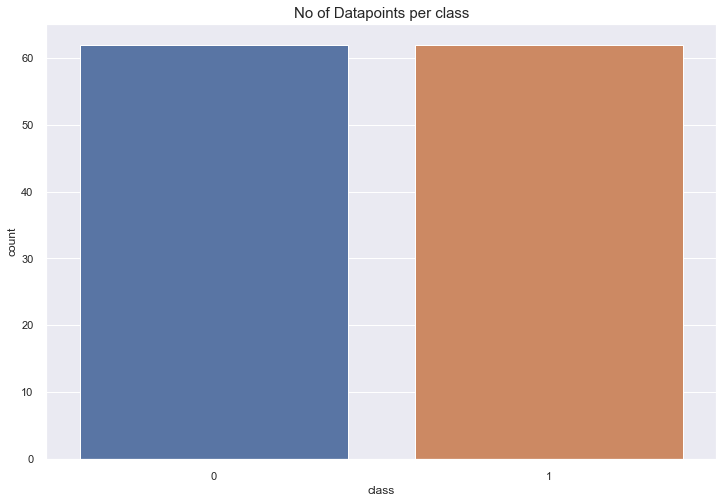

In [198]:
plt.title('No of Datapoints per class', fontsize=15)
sns.countplot(train1['class'])
plt.xticks(rotation=0)
plt.show()

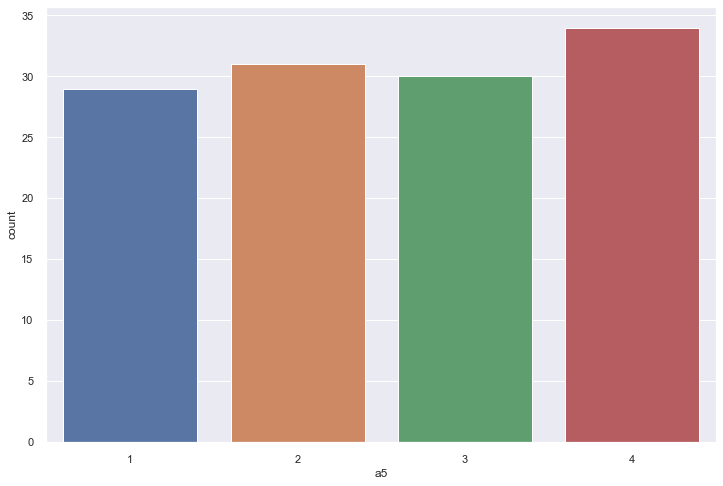

In [202]:
sns.countplot(train1['a5'])
plt.xticks(rotation=0)
plt.show()

In [223]:
# representing only 6 dimensions 
train1_dims = train1[['a1',	'a2', 'a3',	'a4', 'a5',	'a6']]
train1_dims.head()

,a1,a2,a3,a4,a5,a6
0,1,1,1,1,3,1
1,1,1,1,1,3,2
2,1,1,1,3,2,1
3,1,1,1,3,3,2
4,1,1,2,1,2,1


<AxesSubplot:>

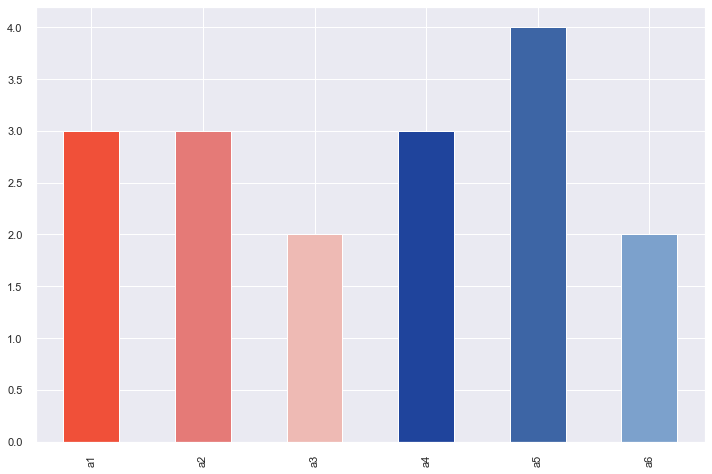

In [260]:
unique = train1_dims.nunique()
unique.plot(kind='bar', 
           color=c)

In [227]:
train1_mean_std = train1_dims.agg([np.mean, np.std])
train1_mean_std

,a1,a2,a3,a4,a5,a6
mean,1.935484,2.096774,1.475806,2.008065,2.556452,1.548387
std,0.813923,0.810694,0.501440,0.831259,1.128366,0.499672


<AxesSubplot:>

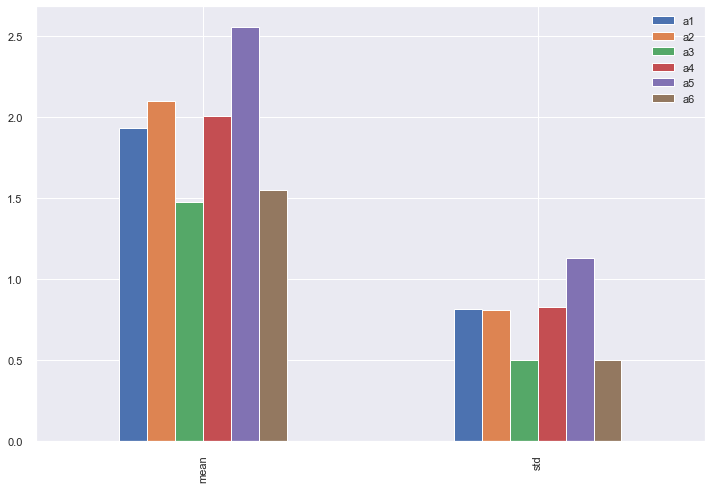

In [226]:
train1_mean_std.plot(kind = 'bar')

In [246]:
# correlation of only 6 dimensions 
train1_corr = train1_dims.corr()
train1_corr.style.background_gradient(cmap='viridis') # Blues cubehelix RdBu PuOr viridis binary jet rainbow gray

,a1,a2,a3,a4,a5,a6
a1,1.000000,-0.027425,0.016065,-0.095356,-0.173050,0.107691
a2,-0.027425,1.000000,0.005806,0.167732,0.029530,0.008417
a3,0.016065,0.005806,1.000000,-0.028785,0.045540,0.053383
a4,-0.095356,0.167732,-0.028785,1.000000,0.055851,0.087135
a5,-0.173050,0.029530,0.045540,0.055851,1.000000,0.088845
a6,0.107691,0.008417,0.053383,0.087135,0.088845,1.000000


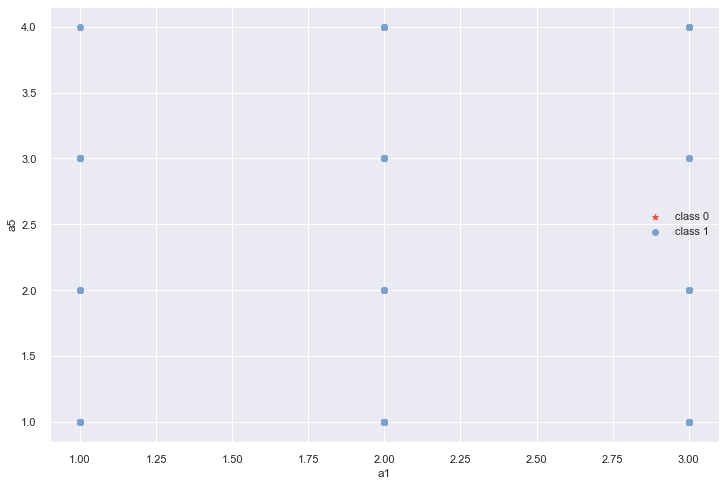

In [253]:
# trying scatter plot of highly correlated attributes
plt.scatter(train1[train1['class'] == 0]['a1'],
            train1[train1['class'] == 0]['a5'], color=c[0], marker='*', label='class 0')
plt.scatter(train1[train1['class'] == 1]['a1'],
            train1[train1['class'] == 1]['a5'], color=c[5], label='class 1')
plt.xlabel('a1')
plt.ylabel('a5')
plt.legend()
plt.show()

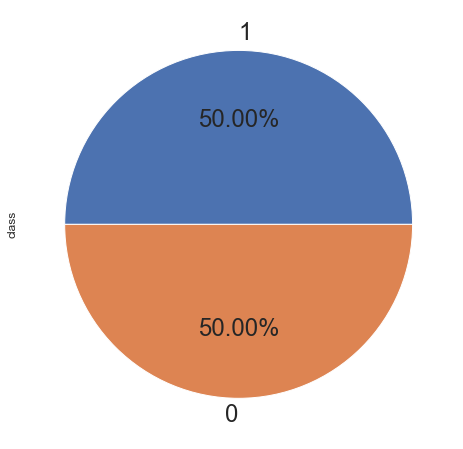

In [262]:
train1['class'].value_counts().plot(kind='pie', y='count', #figsize=(9,9),
                                #title='Class', 
                                #autopct='%1.0f%%',
                                autopct = "%.2f%%",
                                fontsize = 24, 
                                )
plt.show()


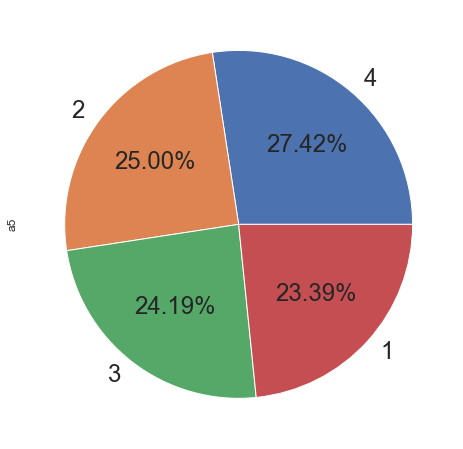

In [263]:
train1['a5'].value_counts().plot(kind='pie', y='count', #figsize=(9,9),
                                #title='Class', 
                                #autopct='%1.0f%%',
                                autopct = "%.2f%%",
                                fontsize = 24, 
                                )
plt.show()


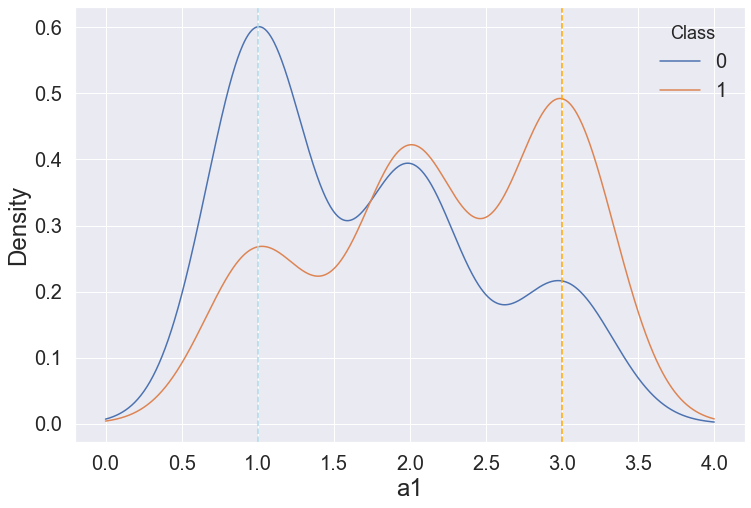

In [279]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a1'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a1', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(1, color = "lightblue", linestyle='--')
plt.axvline(3, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

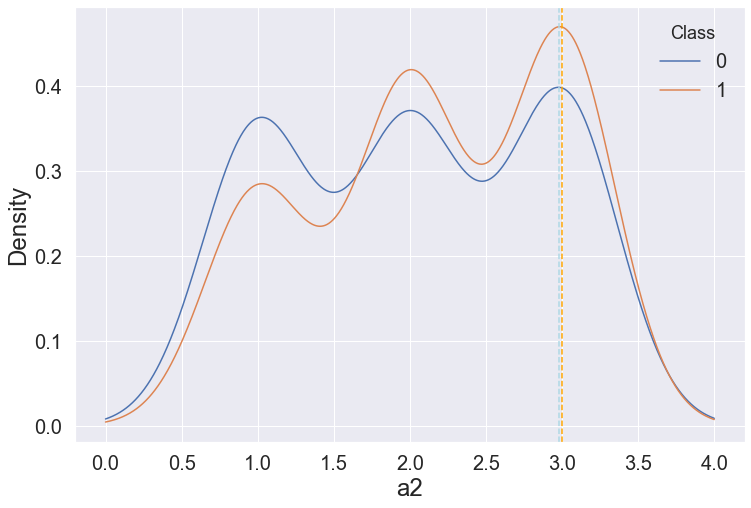

In [284]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a2'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a2', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(2.98, color = "lightblue", linestyle='--')
plt.axvline(3, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

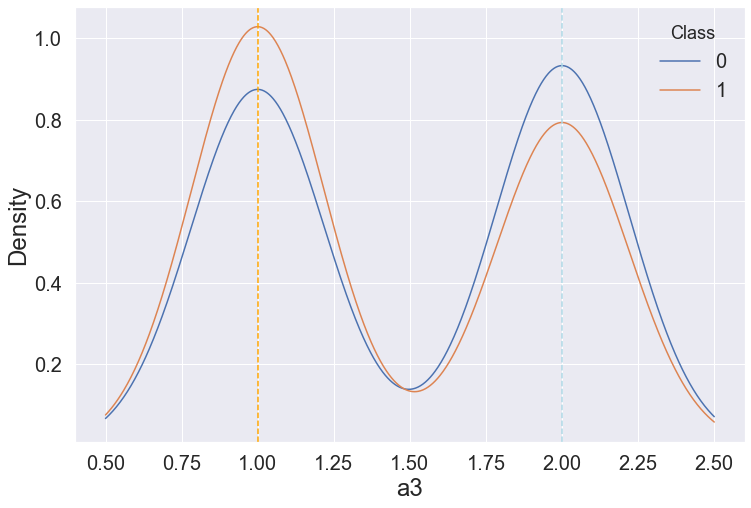

In [286]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a3'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a3', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(2, color = "lightblue", linestyle='--')
plt.axvline(1, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

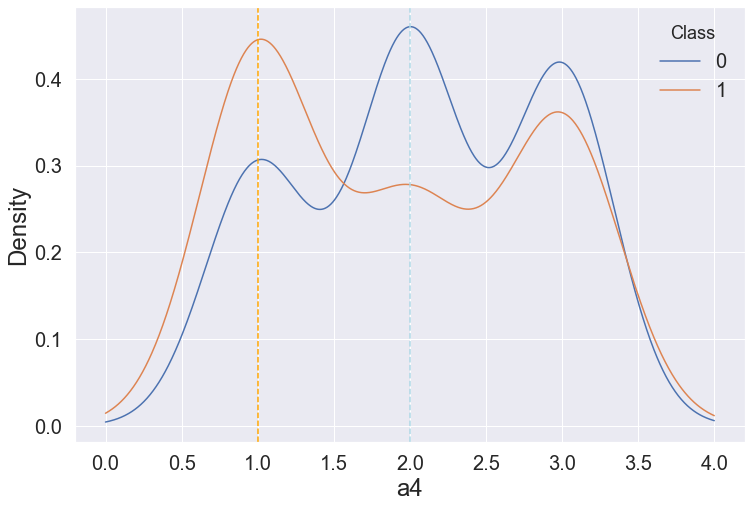

In [287]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a4'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a4', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(2, color = "lightblue", linestyle='--')
plt.axvline(1, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

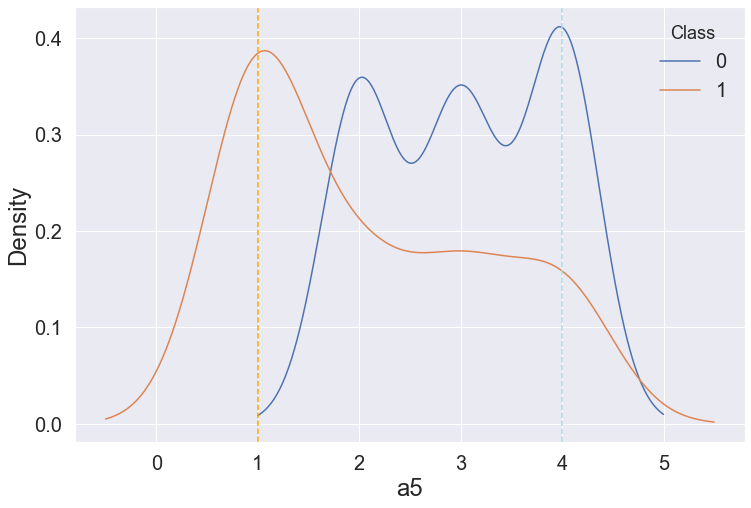

In [277]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a5'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a5', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(4, color = "lightblue", linestyle='--')
plt.axvline(1, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

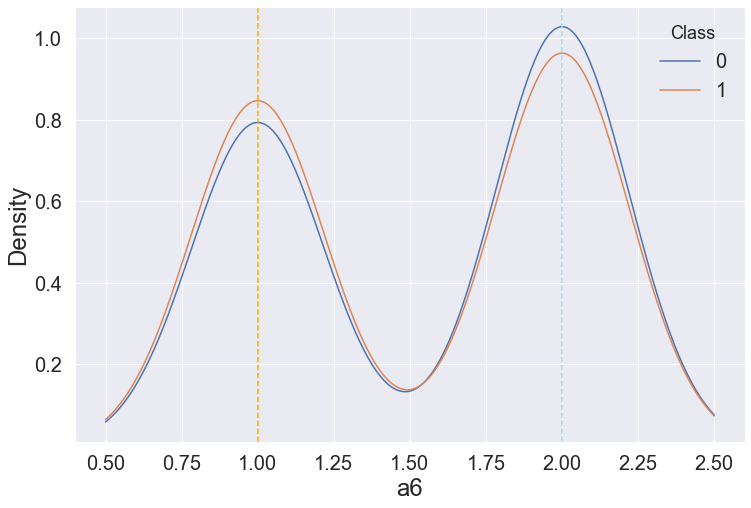

In [288]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a6'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a6', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(2, color = "lightblue", linestyle='--')
plt.axvline(1, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

### 1. SVM

Parameters to Tune:
* Kernel {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}
* Regularization - C - tells the SVM optimization how much we want to avoid misclassifying each training example
* Gamma {'scale', 'auto'} 
        Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
        - if ``gamma='scale'`` (default) is passed then it uses
          1 / (n_features * X.var()) as value of gamma,
        - if 'auto', uses 1 / n_features.
* Margin 

In [205]:
#Create a svm Classifier
clf = svm.SVC(random_state=42) # Linear Kernel

#Train the model using the train 1 set
clf.fit(X_train1, y_train1)

#Predict the response for test dataset
y_pred1 = clf.predict(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.8333333333333334
F1-score [0.84347826 0.82178218]
              precision    recall  f1-score   support

           0       0.80      0.90      0.84       216
           1       0.88      0.77      0.82       216

    accuracy                           0.83       432
   macro avg       0.84      0.83      0.83       432
weighted avg       0.84      0.83      0.83       432



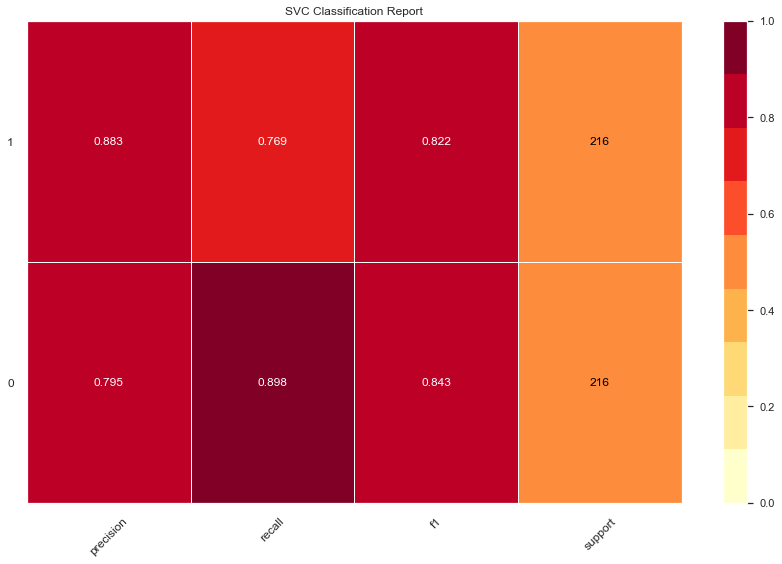

<AxesSubplot:title={'center':'SVC Classification Report'}>

In [219]:
clf = svm.SVC(random_state=42) # Linear Kernel
## Specify the target classes
#classes = ["0", "1"]

visualizer = ClassificationReport(clf, support=True) #classes=classes, 

visualizer.fit(X_train1, y_train1)        # Fit the visualizer and the model
visualizer.score(X_test1, y_test1)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [19]:
#Train the model using the train 2 set
clf.fit(X_train2, y_train2)

#Predict the response for test dataset
y_pred2 = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test2, y_pred2))
print('F1-score %s' % f1_score(y_test2, y_pred2, average=None))
print(classification_report(y_test2, y_pred2))

Accuracy 0.6805555555555556
F1-score [0.78504673 0.37837838]
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       290
           1       0.53      0.30      0.38       142

    accuracy                           0.68       432
   macro avg       0.62      0.58      0.58       432
weighted avg       0.65      0.68      0.65       432



In [20]:
#Train the model using the train 3 set
clf.fit(X_train3, y_train3)

#Predict the response for test dataset
y_pred3 = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test3, y_pred3))
print('F1-score %s' % f1_score(y_test3, y_pred3, average=None))
print(classification_report(y_test3, y_pred3))

Accuracy 0.9699074074074074
F1-score [0.96912114 0.97065463]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.94      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



### Hyperparameter Tuning for SVM

In [23]:
#Create a svm Classifier
clf = svm.SVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train1, y_train1)
grid_search.best_estimator_

SVC(C=100, kernel='poly', random_state=42)

In [24]:
#Create a svm Classifier
clf = svm.SVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train1, y_train1)
clf = grid_search.best_estimator_

y_pred1 = clf.predict(X_test1)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.9212962962962963
F1-score [0.92018779 0.92237443]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       216
           1       0.91      0.94      0.92       216

    accuracy                           0.92       432
   macro avg       0.92      0.92      0.92       432
weighted avg       0.92      0.92      0.92       432



In [25]:
#Create a svm Classifier
clf = svm.SVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train2, y_train2)
clf = grid_search.best_estimator_

y_pred2 = clf.predict(X_test2)
#y_score2 = clf.predict_proba(X_test2)

print('Accuracy %s' % accuracy_score(y_test2, y_pred2))
print('F1-score %s' % f1_score(y_test2, y_pred2, average=None))
print(classification_report(y_test2, y_pred2))

Accuracy 0.8125
F1-score [0.85245902 0.74285714]
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       290
           1       0.68      0.82      0.74       142

    accuracy                           0.81       432
   macro avg       0.79      0.82      0.80       432
weighted avg       0.83      0.81      0.82       432



In [26]:
#Create a svm Classifier
clf = svm.SVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train3, y_train3)
clf = grid_search.best_estimator_

y_pred3 = clf.predict(X_test3)
#y_score3 = clf.predict_proba(X_test3)

print('Accuracy %s' % accuracy_score(y_test3, y_pred3))
print('F1-score %s' % f1_score(y_test3, y_pred3, average=None))
print(classification_report(y_test3, y_pred3))

Accuracy 0.9328703703703703
F1-score [0.93176471 0.93394077]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       204
           1       0.97      0.90      0.93       228

    accuracy                           0.93       432
   macro avg       0.93      0.93      0.93       432
weighted avg       0.94      0.93      0.93       432



### 2. Linear SVM 

For linear SVM we need to take max two features to run the algorithm

#### Feature Selection

##### Univariate Feature Selection

In [264]:
sel = SelectKBest(k=2)
X_train1_sel = sel.fit_transform(X_train1_mm, y_train1)
X_test1_sel = sel.fit_transform(X_test1_mm, y_test1)
X_train1_sel.shape, X_test1_sel.shape

((124, 2), (432, 2))

In [146]:
X_train_sel_df = pd.DataFrame({'x':X_train1_sel[:,0], 'y':X_train1_sel[:,1] ,'class':y_train1})
X_train_sel_df

,x,y,class
0,-1.154015,0.394684,1
1,-1.154015,0.394684,1
2,-1.154015,-0.495149,1
3,-1.154015,0.394684,1
4,-1.154015,-0.495149,1
...,...,...,...
119,1.313189,1.284516,1
120,1.313189,-1.384981,1
121,1.313189,-0.495149,1
122,1.313189,0.394684,1


##### PCA

In [267]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train1)
X_train1_pca = pca.transform(X_train1)
X_test1_pca = pca.transform(X_test1)

#### linearSVC  (?sucks)

In [269]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

clf.fit(X_train1_sel, y_train1)
y_pred1 = clf.predict(X_test1_sel)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.6666666666666666
F1-score [0.66666667 0.66666667]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       216
           1       0.67      0.67      0.67       216

    accuracy                           0.67       432
   macro avg       0.67      0.67      0.67       432
weighted avg       0.67      0.67      0.67       432



In [271]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

clf.fit(X_train1_pca, y_train1)
y_pred1 = clf.predict(X_test1_pca)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.6666666666666666
F1-score [0.66666667 0.66666667]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       216
           1       0.67      0.67      0.67       216

    accuracy                           0.67       432
   macro avg       0.67      0.67      0.67       432
weighted avg       0.67      0.67      0.67       432



In [265]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train1_sel, y_train1)
clf = grid_search.best_estimator_

y_pred1 = clf.predict(X_test1_sel)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.6666666666666666
F1-score [0.66666667 0.66666667]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       216
           1       0.67      0.67      0.67       216

    accuracy                           0.67       432
   macro avg       0.67      0.67      0.67       432
weighted avg       0.67      0.67      0.67       432



In [72]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=50) 
# cv : int, cross-validation generator or an iterable, default=None
#         Determines the cross-validation splitting strategy.

grid_search.fit(X_train1_st, y_train1)
clf = grid_search.best_estimator_

y_pred1 = clf.predict(X_test1_st)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.6620370370370371
F1-score [0.66203704 0.66203704]
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       216
           1       0.66      0.66      0.66       216

    accuracy                           0.66       432
   macro avg       0.66      0.66      0.66       432
weighted avg       0.66      0.66      0.66       432



In [73]:
clf

LinearSVC(C=0.001, random_state=42)

In [64]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=50) 
# cv : int, cross-validation generator or an iterable, default=None
#         Determines the cross-validation splitting strategy.

grid_search.fit(X_train1_mm, y_train1)
clf = grid_search.best_estimator_

y_pred1 = clf.predict(X_test1_mm)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.6666666666666666
F1-score [0.66666667 0.66666667]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       216
           1       0.67      0.67      0.67       216

    accuracy                           0.67       432
   macro avg       0.67      0.67      0.67       432
weighted avg       0.67      0.67      0.67       432



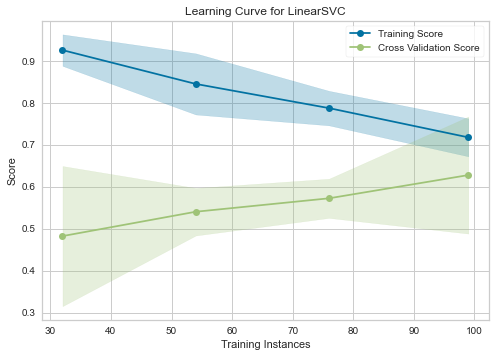

<AxesSubplot:title={'center':'Learning Curve for LinearSVC'}, xlabel='Training Instances', ylabel='Score'>

In [65]:
lc3_viz = LearningCurve(clf, scoring='accuracy')
lc3_viz.fit(X_train1_mm, y_train1)
lc3_viz.show()

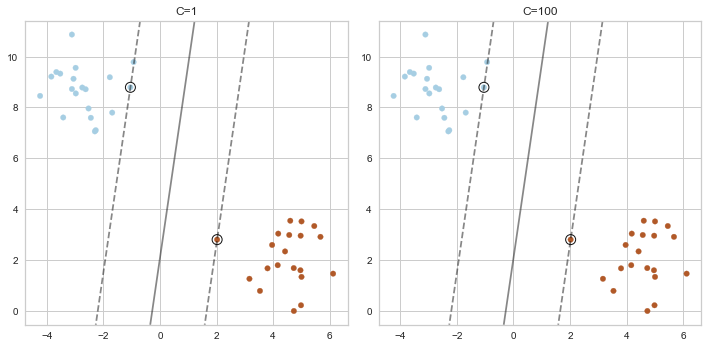

In [83]:
X, y = make_blobs(n_samples=40, centers=2, random_state=42)
#X = X_train1
#y = y_train1

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = svm.LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y - 1) * decision_function <= 1)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
    #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
plt.tight_layout()
plt.show()

### 3. SVM with Linear Kernel

In [123]:
#Create a svm Classifier
clf = svm.SVC(random_state=42, kernel='linear')

# Grid Search
param_grid = [
  {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, n_jobs=50)
grid_search.fit(X_train1, y_train1)
grid_search.best_estimator_

SVC(C=0.05, kernel='linear', random_state=42)

In [124]:
#Create a svm Classifier
clf = svm.SVC(random_state=42, kernel='linear', C=0.05)

clf.fit(X_train1, y_train1)

y_pred1 = clf.predict(X_test1)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.6712962962962963
F1-score [0.67281106 0.66976744]
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       216
           1       0.67      0.67      0.67       216

    accuracy                           0.67       432
   macro avg       0.67      0.67      0.67       432
weighted avg       0.67      0.67      0.67       432



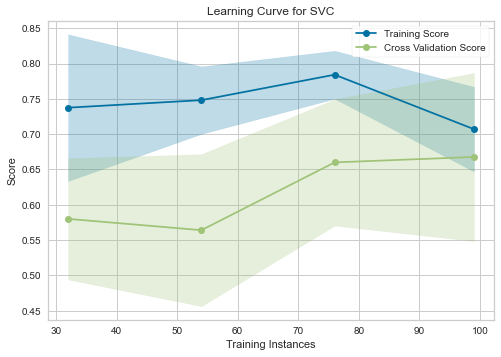

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [126]:
lc_1 = LearningCurve(clf, scoring='accuracy')
lc_1.fit(X_train1, y_train1)
lc_1.show()

### Model Evaluation

In [203]:
#from scikitplot.metrics import plot_roc
#from scikitplot.metrics import plot_precision_recall
#from scikitplot.metrics import plot_cumulative_gain
#from scikitplot.metrics import plot_lift_curve

#### Confusion Matrix

In [207]:
cf = confusion_matrix(y_test1, y_pred1)
cf

array([[196,  20],
       [ 14, 202]], dtype=int64)

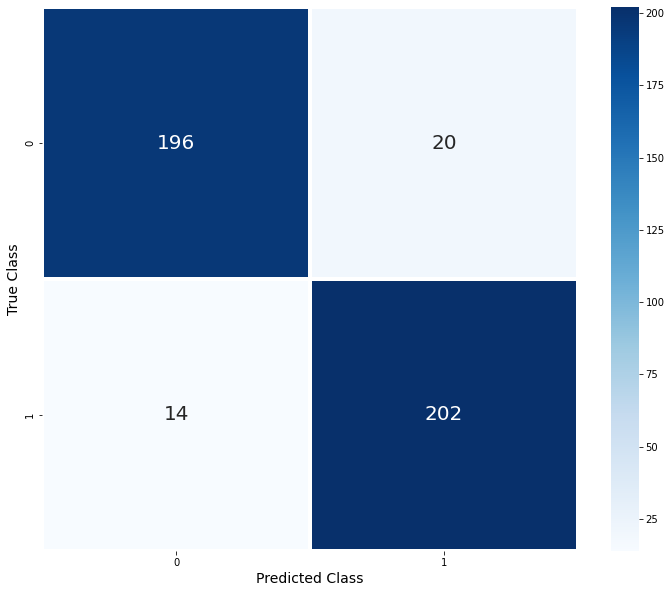

In [208]:
activities = ['0', '1']

ax = plt.subplots(figsize = (12,10))
ax = sns.heatmap(cf, annot=True, fmt="d", annot_kws={"size": 20}, linewidths=4, cmap="Blues")
ax.set_xticklabels(activities, fontsize=10)
ax.set_xlabel('Predicted Class', fontsize=14)
ax.set_yticklabels(activities, fontsize=10)
ax.set_ylabel('True Class', fontsize=14)

plt.show()

## ML-CUP22

### Read datasets

In [ ]:
ml_cup22_train = pd.read_csv('../data/ML-CUP22-TR.csv', header=None)
ml_cup22_test = pd.read_csv('../data/ML-CUP22-TS.csv', header=None)

In [289]:
ml_cup22_train.shape, ml_cup22_test.shape

((1492, 12), (529, 10))